# Supernova SNR (aka Detection Rate) metric

This metric corresponds to the detection rate of a faint [(x1,color) = (-2.0,0.2)] supernovae. It is estimated by comparing,at a given time MJDcurcur,the Signal-to-Noise Ratio (SNR) of a supernovae with T0=MJDcurcur -10 to the SNR one would have with a regular cadence SNRrefref(mean value of the corresponding period of study) : if SNR ≥≥ SNRrefref, the supernovae can be detected.This metric is sensitive to internight gap variations.

Input parameters

- band
- z : redshift value for the study
- Li_files : list of npy files with light curves
- mag_to_flux : list of npy files with mag to flux conversion
- config_fake : dict of parameters to simulate "fake" observations (to estimate SNRrefref)



## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from sn_metrics.sn_snr_metric import SNSNRMetric
from sn_tools.sn_cadence_tools import ReferenceData
import sn_plotter_metrics.snrPlot as sn_plot

## DB file choice

In [2]:
dbName = 'descddf_v1.5_10yrs.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
#propinfo, proptags = opsimdb.fetchPropInfo()
#print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

Cannot access Config table to retrieve runLength; using default 10 years


## Parameter choice (field type, bands, z, ...)

In [15]:
fieldtype='WFD' #fieldtype: DD or WFD

propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)

if fieldtype == 'DD':
    coadd = True
    fracmin = 0.05
    fracmax = 1.0
if fieldtype == 'WFD':
    coadd = False
    fracmin = 0.05
    fracmax = 1.0
    
Li_files = ['../reference_files/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../reference_files/Mag_to_Flux_SNCosmo.npy']
names_ref = ['SNCosmo']
fake_file = '../input/Fake_cadence/Fake_cadence_snrmetric.yaml'

bands = 'r'
z=0.3
nside = 64

No proposal table available - no proposalIds have been assigned.
proptags and propinfo {} {}
No WFD proposals found


## Define slicer

In [16]:
slicer = slicers.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make MAF bundle of metrics

In [17]:
bundles=[]
names = []
sql_i = '(fieldRA >= 0.) AND (fieldRA<36.)'
sql_i += ' AND (fieldDec >=-30.) AND (fieldDec<0.) '
for band in bands:
    #sql_i = sqlconstraint+' AND '
    sql_i += 'AND filter = "%s"' % (band)

    lim_sn = ReferenceData(Li_files, mag_to_flux_files, band, z)

    metric = SNSNRMetric(lim_sn=lim_sn, names_ref=names_ref,fake_file=fake_file, coadd=coadd, z=z,season=[2])
    bundles.append(metricBundles.MetricBundle(metric, slicer, sql_i))
    names.append(band)

bdict = dict(zip(names, bundles)) #bundle dict

## Run the bundle of metrics

In [18]:
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
mbg = metricBundles.MetricBundleGroup(bdict, opsimdb,
                                          outDir=outDir, resultsDb=resultsDb)

mbg.runAll()

Querying database SummaryAllProps with constraint (fieldRA >= 0.) AND (fieldRA<36.) AND (fieldDec >=-30.) AND (fieldDec<0.) AND filter = "r" for columns ['observationStartMJD', 'visitExposureTime', 'visitTime', 'seeingFwhmEff', 'numExposures', 'filter', 'seeingFwhmGeom', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'observationId', 'night']
Found 23736 visits
Running:  ['r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Display the results

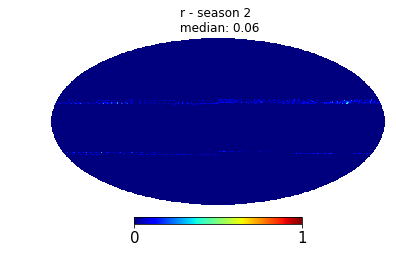

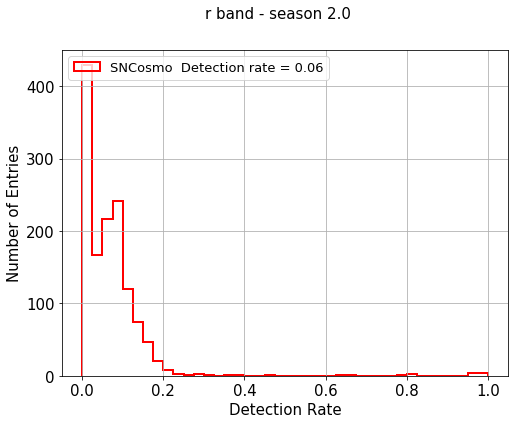

In [24]:
%matplotlib inline
import pandas as pd
for band, val in bdict.items():
    metValues = val.metricValues[~val.metricValues.mask]
    res = pd.DataFrame()
    for vals in metValues:
        #print(type(vals))
        if vals is not None:
            res = pd.concat((res,vals))
        """"
            if res is None:
                res = vals
            else:
                res = np.concatenate((res, vals))
        """
    #res = np.unique(res)

    res = res.to_records(index=False)
    sn_plot.detecFracPlot(res,nside, names_ref)

    sn_plot.detecFracHist(res, names_ref)